In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from numpy import pi, sqrt

np.set_printoptions(suppress=True)

def measure(state, size=1):
    """For a given state returns a measurement (or \'size\' measurements, if specified) of the state in
    the computational basis along with its wavefunction (probabilities of each outcome)"""
    n = state.shape[0]
    probs = np.abs(state.dag().full())**2
    probs = probs.reshape(n)
    if size>1:
        draw = np.random.choice(n,p=probs,size=size)
    else:
        draw = np.random.choice(n,p=probs)
    return(draw,list(probs))

In [5]:
def err(sigma):
    return(random.gauss(0, sigma))

X = Qobj([[0,1],[1,0]])
def MS(chi, sgm):
    prm = chi + err(sgm)
    return(np.cos(prm)*tensor(qeye(2),qeye(2)) -1j * np.sin(prm)*tensor(X,X))

def D0(sgm):
    return(tensor(ry(pi/2+err(sgm)),qeye(2))*tensor(qeye(2),ry(pi/2+err(sgm)))*MS(pi/4,sgm)*tensor(rx(-pi/2+err(sgm)),qeye(2))*tensor(qeye(2),rx(-pi/2+err(sgm)))*tensor(ry(-pi/2+err(sgm)),qeye(2))*tensor(qeye(2),ry(-pi/2+err(sgm))))

def simulation_rankone_error(step_e, max_e, nb_agnts, sgm):
    """
    simulation_rankone simulates for nb_agnts agents the quantum walk (and also the classical walk if clssc is set)
    on the subnetwork associated to the first percept for epsilon <= max_e with step step_e. It stores the number of
    calls of U before a flagged action is hit for each simulation in NUss for the quantum agents and in NUss_clssc for
    the classical agents. It also stores the number of times the first percept or the second percept are hit in N1s
    and N2s respectively.
    """
    epsilons = np.arange(max_e, 0.0-step_e, -step_e)[:-1]
    N1s = []
    N2s = []
    NUss = []
    flagged = 1
    old_perc = 0
    for epsilon in epsilons:
        p1 = epsilon/3
        me = math.ceil(1/sqrt(epsilon))
        N1 = 0
        N2 = 0
        NUs = []
        for i in range(nb_agnts):
            NU = 0
            fnd = False
            while not fnd:
                R1 = tensor(basis(2,0),basis(2,0))
                m = random.randint(0,me)
                NU+=3*m
                Ux = ((0.5*math.pi+err(sgm))*0.5j*(tensor(sigmax(),qeye(2))+tensor(qeye(2),sigmax()))).expm()
                Uxb = ((-0.5*math.pi+err(sgm))*0.5j*(tensor(sigmax(),qeye(2))+tensor(qeye(2),sigmax()))).expm()
                Uz2 = tensor(qeye(2),rz(2*math.acos(sqrt(p1/epsilon))+err(sgm)))
                Uz1 = tensor(rz(2*math.acos(sqrt(epsilon))+err(sgm)),qeye(2))
                Uz1b = tensor(rz(pi+err(sgm)),qeye(2))
                U = Ux*Uz2*Uz1*Uxb
                R1 = U*R1
                for j in range(m):
                    Ux = ((0.5*math.pi+err(sgm))*0.5j*(tensor(sigmax(),qeye(2))+tensor(qeye(2),sigmax()))).expm()
                    Uxb = ((-0.5*math.pi+err(sgm))*0.5j*(tensor(sigmax(),qeye(2))+tensor(qeye(2),sigmax()))).expm()
                    Uz2 = tensor(qeye(2),rz(2*math.acos(sqrt(p1/epsilon))+err(sgm)))
                    Uz1 = tensor(rz(2*math.acos(sqrt(epsilon))+err(sgm)),qeye(2))
                    Uz1b = tensor(rz(pi+err(sgm)),qeye(2))
                    U = Ux*Uz2*Uz1*Uxb
                    W = U*D0(sgm)*U.dag()
                    R1 = Uz1b*R1
                    R1 = W*R1
                res = measure(R1)[0]
                if res<=flagged:
                    fnd = True
                    if res==0:
                        N1+=1
                    else:
                        N2+=1
            NUs+=[NU]
        NUss+=[NUs]
        N1s+=[N1]
        N2s+=[N2]
        perc = 100*(1-epsilon/epsilons[0])
        if perc >= old_perc+10:
            old_perc = 10*int(perc/10)
            print(int(perc),"%")
    print("done")
    return(epsilons, NUss, N1s, N2s)

In [6]:
epsilons, NUss, N1s, N2s = simulation_rankone_error(0.0005, 0.05, 1000, pi/100)

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
done


In [7]:
import pickle
f = open('simulation_epsilon_error-pi-100.save', 'wb')
pickle.dump([epsilons, NUss, N1s, N2s], f)
f.close()

In [3]:
import pickle
file = open('simulation_epsilon_error-pi-100.save', 'rb')
[epsilons, NUss, N1s, N2s] = pickle.load(file)
file.close()

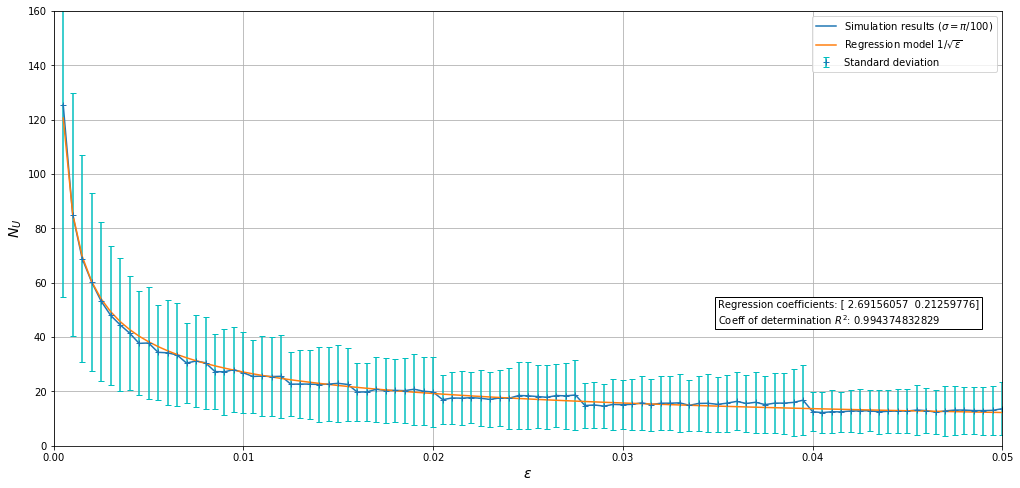

Curve fitting coefficients :  [ 2.69156057  0.21259776]
Coefficient of determination R^2 :  0.994374832829


In [4]:
NUss_mean = []
NUss_std = []
for NUs in NUss:
    NUss_mean+=[np.mean(NUs)]
    NUss_std+=[np.std(NUs)]

curve_fit = np.polyfit(1/np.sqrt(epsilons), NUss_mean, 1, full=True)
coeff = curve_fit[0]
res = curve_fit[1][0]
rsqr = 1 - res / (len(NUss_mean) * np.var(NUss_mean))

plt.figure(figsize=(17,8))
errbar = plt.errorbar(epsilons, NUss_mean, np.array(NUss_std), ecolor='c', linestyle='None', marker='+', capsize=3, label='Standard deviation')
results, = plt.plot(epsilons, NUss_mean, label='Simulation results ($\sigma=\pi/100$)')
model, = plt.plot(epsilons, coeff[0]/np.sqrt(epsilons)+coeff[1], label='Regression model $1/\sqrt{\epsilon}$')
axes = plt.gca()
axes.set_ylim([0,160])
axes.set_xlim([0,0.05])

plt.legend(handles=[results, model, errbar])
plt.text(0.035,45,'Regression coefficients: '+str(coeff)+'\nCoeff of determination $R^2$: '+str(rsqr),bbox=dict(facecolor='white',edgecolor='black',boxstyle='square'))

plt.xlabel('$\epsilon$', fontsize=14)
plt.ylabel('$N_U$', fontsize=14)
plt.grid(True)
plt.show()
print("Curve fitting coefficients : ", coeff)
print('Coefficient of determination R^2 : ', rsqr)